In [1]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import zipfile
import rasterio as rio
from pyproj import Proj, transform

import warnings
warnings.filterwarnings('ignore')

In [2]:
def list_unzip_files(folder_path, unzip_dbf=False):
    # List all files in the folder
    all_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            relative_path = os.path.relpath(os.path.join(root, file), folder_path)
            all_files.append(relative_path)
    # If there are any dbf zip files, unzip them
    if unzip_dbf:
        for file_path in files:
            if file_path.endswith('.zip'):
                if not os.path.exists(f"{folder_path}/{file_path[:-4]}"):
                    with zipfile.ZipFile(f"{folder_path}/{file_path}", 'r') as zip_ref:
                        zip_ref.extractall(folder_path)
    return all_files

# Define the folder paths for shapefiles and csv files
folder_path = 'input_data/raw/fires'
files = list_unzip_files(folder_path, unzip_dbf=True)

In [3]:
def load_data(files, folder_path):
    dataframes = []
    # Load all shp and csv files
    for file_path in files:
        if file_path.endswith('.shp'):
            df = gpd.read_file(f"{folder_path}/{file_path}")
        elif file_path.endswith('.csv'):
            df = pd.read_csv(f"{folder_path}/{file_path}")
        else:
            continue
        df.columns = map(str.upper, df.columns)
        dataframes.append(df)
    # Concatenate all dataframes
    fire_data = pd.concat(dataframes, ignore_index=True)
    return fire_data

# Initialize an empty list to store dataframes
fire_data = load_data(files, folder_path)

In [4]:
def preprocess_fires(fire_data):
    # Drop duplicates time and location
    fire_data.drop_duplicates(subset=['ACQ_DATE', 'ACQ_TIME', 'LATITUDE', 'LONGITUDE'], inplace=True)
    # Drop unnecessary columns
    fire_data.drop(columns=['COUNTRY_ID', 'SCAN', 'TRACK', 'SATELLITE', 'CONFIDENCE', 'VERSION', 'FRP', 'DAYNIGHT', 'BRIGHTNESS', 'BRIGHT_T31', 'TYPE', 'GEOMETRY', 'INSTRUMENT'], inplace=True)
    # Drop rows with missing or nan values
    fire_data.dropna(inplace=True)
    # Transform the date to datetime format
    fire_data['ACQ_DATE'] = fire_data['ACQ_DATE'].apply(lambda x: pd.to_datetime(x).date())
    # Transform the time to integer format
    fire_data['ACQ_TIME'] = fire_data['ACQ_TIME'].astype(int)
    # Reduce the precision of the coordinates using two decimal places, which is approximately 1.1 km
    # (https://support.oxts.com/hc/en-us/articles/115002885125-Level-of-Resolution-of-Longitude-and-Latitude-Measurements)
    fire_data['LATITUDE'] = fire_data['LATITUDE'].round(2)
    fire_data['LONGITUDE'] = fire_data['LONGITUDE'].round(2)
    return fire_data

# Preprocess the fire data
fire_data = preprocess_fires(fire_data)

In [5]:
def filter_fires_date(fire_data, start_date, end_date):
    # Filter the fire data based on the input parameters
    filtered_data = fire_data[(fire_data['ACQ_DATE'] >= start_date) & (fire_data['ACQ_DATE'] <= end_date)]
    # Reset the index
    filtered_data.reset_index(drop=True, inplace=True)
    return filtered_data

# Filter the fire data based on a specific date range
start_date = pd.to_datetime('2014-12-01').date()
end_date = pd.to_datetime('today').date()
fire_data = filter_fires_date(fire_data, start_date, end_date)

In [6]:
def filter_data_border(data, path_to_border):
    # Load the shapefile containing the administrative borders of Ukraine
    ukraine_borders = gpd.read_file(path_to_border)
    # Ensure the data is a GeoDataFrame
    data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.LONGITUDE, data.LATITUDE))
    # Set the same coordinate reference system (CRS) for both GeoDataFrames
    data_gdf.set_crs(epsg=4326, inplace=True)
    ukraine_borders.set_crs(epsg=4326, inplace=True)
    # Perform a spatial join to filter datapoints within Ukraine borders
    data_in_ukraine = gpd.sjoin(data_gdf, ukraine_borders, how='inner')
    # Drop the geometry column as it's no longer needed
    data_in_ukraine.drop(columns=['geometry', 'source', 'name', 'index_right'], inplace=True)
    # Reset the index
    data_in_ukraine.reset_index(drop=True, inplace=True)
    # Make sure all columns are in uppercase
    data_in_ukraine.columns = map(str.upper, data_in_ukraine.columns)
    # Rename the ID column to OBLAST_ID
    data_in_ukraine.rename(columns={'ID': 'OBLAST_ID'}, inplace=True)
    # Generate a unique identifier for each grid cell
    data_in_ukraine['GRID_CELL'] = data_in_ukraine['LATITUDE'].astype(str) + '_' + data_in_ukraine['LONGITUDE'].astype(str)
    return data_in_ukraine

# Filter the fire data based on the administrative borders of Ukraine
# fire_data = fire_data.sample(500000)
fire_data = filter_data_border(fire_data, 'input_data/raw/ukr_borders/ua.shp') # https://simplemaps.com/gis/country/ua

In [7]:
def generate_counts(fire_data):
    # sort by date
    fire_data = fire_data.sort_values(by='ACQ_DATE')
    # Generate the day of the year
    fire_data['DAY_OF_YEAR'] = fire_data['ACQ_DATE'].apply(lambda x: x.timetuple().tm_yday)
    # Generate the number of fires per grid cell for the specific day (ACQ_DATE)
    fire_data['FIRE_COUNT_CELL'] = fire_data.groupby(['GRID_CELL', 'ACQ_DATE'])['ACQ_DATE'].transform('count')
    # Generate the number of fires of the neighboring grid cells for the specific day (ACQ_DATE) by rounding to 0 and 1 decimal place
    for i in [0, 1]:
        fire_data[f'GRID_CELL_NEIGHBOR_{i}'] = (fire_data['LATITUDE']).round(i).astype(str) + '_' + (fire_data['LONGITUDE']).round(i).astype(str)
        fire_data[f'FIRE_COUNT_CELL_NEIGHBOR_{i}'] = fire_data.groupby([f'GRID_CELL_NEIGHBOR_{i}', 'ACQ_DATE'])['ACQ_DATE'].transform('count')
    # Generate the number of fires per region (ID) for the specific day (ACQ_DATE)
    fire_data['FIRE_COUNT_OBLAST'] = fire_data.groupby(['OBLAST_ID', 'ACQ_DATE'])['ACQ_DATE'].transform('count')
    # Generate average number of fires per grid cell, neighboring grid cells, and region for the last 7 and 30 days
    for i in [7, 30]:
        fire_data[f'FIRE_COUNT_CELL_AVG_{i}'] = fire_data.groupby('GRID_CELL')['FIRE_COUNT_CELL'].transform(lambda x: x.rolling(i, min_periods=1).mean())
        for j in [0, 1]:
            fire_data[f'FIRE_COUNT_CELL_NEIGHBOR_{j}_AVG_{i}'] = fire_data.groupby(f'GRID_CELL_NEIGHBOR_{j}')[f'FIRE_COUNT_CELL_NEIGHBOR_{j}'].transform(lambda x: x.rolling(i, min_periods=1).mean())
        fire_data[f'FIRE_COUNT_OBLAST_AVG_{i}'] = fire_data.groupby('OBLAST_ID')['FIRE_COUNT_OBLAST'].transform(lambda x: x.rolling(i, min_periods=1).mean())
    return fire_data

# Perform feature engineering
fire_data = generate_counts(fire_data)
# Filter the fire data based on a specific date range
start_date = pd.to_datetime('2015-01-01').date()
fire_data = filter_fires_date(fire_data, start_date, end_date)

In [8]:
def generate_population_density(fire_data, path_to_population, round_precision=2):
    # Load the population density data
    pop_density_df = pd.read_csv(path_to_population)
    # Rename the columns to be more descriptive
    pop_density_df.columns = ['LONGITUDE', 'LATITUDE', 'POP_DENSITY']
    # Round the latitude and longitude to match the precision used in fire_data
    pop_density_df['LATITUDE'] = pop_density_df['LATITUDE'].round(round_precision)
    pop_density_df['LONGITUDE'] = pop_density_df['LONGITUDE'].round(round_precision)
    # Calculate the average population density for each grid cell
    pop_density_avg = pop_density_df.groupby(['LATITUDE', 'LONGITUDE'])['POP_DENSITY'].mean().reset_index()
    # Create a unique identifier for each grid cell
    pop_density_avg['GRID_CELL'] = pop_density_avg['LATITUDE'].astype(str) + '_' + pop_density_avg['LONGITUDE'].astype(str)
    # Merge the population density data with the fire_data dataframe
    fire_data = fire_data.merge(pop_density_avg[['GRID_CELL', 'POP_DENSITY']], on='GRID_CELL', how='left')
    # Rename the column to indicate it's the population density
    fire_data.rename(columns={'POP_DENSITY': 'POP_DENSITY_CELL_AVG'}, inplace=True)
    return fire_data

# Calculate the population density for each grid cell
fire_data = generate_population_density(fire_data, 'input_data/raw/population/ukr_pd_2020_1km_UNadj_ASCII_XYZ.csv')

In [21]:
# Define the UTM projection (EPSG:32636) and WGS84 projection (EPSG:4326)
wgs84_proj = Proj('epsg:4326')

def load_tif_with_reduced_resolution(tif_path, scale_factor):
    with rio.open(tif_path) as src:
        # Calculate the new shape
        new_height = int(src.height * scale_factor)
        new_width = int(src.width * scale_factor)
        # Read the data with resampling
        data = src.read(
            out_shape=(src.count, new_height, new_width),
            resampling=rio.enums.Resampling.bilinear
        )
        # Scale the transform
        transform_scaled = src.transform * src.transform.scale(
            (src.width / data.shape[-1]),
            (src.height / data.shape[-2])
        )
        # Get the UTM projection from the metadata
        utm_proj = Proj(src.crs)
        return data, np.array(transform_scaled), utm_proj

def utm_to_latlon(utm_coords, utm_proj, wgs84_proj):
    # Function to convert UTM to lat/lon
    lon, lat = transform(utm_proj, wgs84_proj, utm_coords[0], utm_coords[1])
    return lat, lon

def transform_tif_coordinates(data, transform, utm_proj):
    # transform the coordinates of the pixels
    lon = np.zeros(data.shape[1:])
    lat = np.zeros(data.shape[1:])
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            lon[i][j], lat[i][j] = utm_to_latlon((transform[2] + transform[0] * j, transform[5] + transform[4] * i), utm_proj, wgs84_proj)
    return lon, lat

def convert_to_dataframe(data, lon, lat, map_dict):
    # Create a dataframe with the class of the pixel and its longitude and latitude value
    df = pd.DataFrame(data[0].flatten(), columns=['class'])
    # get longitude and latitude values and round them to 2 decimal places
    df['LONGITUDE'] = lon.flatten().round(2)
    df['LATITUDE'] = lat.flatten().round(2)
    # Delete all rows with class 0 (no data)
    df = df[df['class'] != 0]
    # Map the classes to the new classes
    df['CLASS'] = df['class'].map(map_dict)
    df.drop(columns=['class'], inplace=True)
    return df

def merge_dataframes(dataframes):
    # Merge the dataframes
    merged_df = pd.concat(dataframes, ignore_index=True)
    # Drop rows that are not in the Ukraine borders
    merged_df = filter_data_border(merged_df, 'input_data/raw/ukr_borders/ua.shp')
    # Reset the index
    merged_df.reset_index(drop=True, inplace=True)
    return merged_df

def class_percentage_cell(land_use_data):
    # Calculate the percentage of each class for each grid cell
    land_use_percentage = land_use_data.groupby(['GRID_CELL', 'CLASS']).size().unstack(fill_value=0)
    land_use_percentage = land_use_percentage.div(land_use_percentage.sum(axis=1), axis=0)
    land_use_percentage.reset_index(inplace=True)
    return land_use_percentage

# Load the TIFF file with reduced resolution
# Reduce resolution by 90%, i.e., 10m resolution to 100m resolution
scale_factor = 0.1
# Dictionary to merge some of the classes into new classes
# Original classes: 0: 'No data', 1: 'Water', 2: 'Trees', 4: 'Flooded vegetation', 5: 'Crops', 7: 'Built Area', 8: 'Bare ground', 9: 'Snow and ice', 10: 'Clouds', 11: 'Rangeland'
class_transform = {0: 0, 1: 0, 2: 1, 4: 2, 5: 3, 7: 4, 8: 2, 9: 0, 10: 0, 11: 2}

# Iterate over all tif files in the folder
dataframes = []
# get all tif files in the folder using os.listdir
for tif_file in list_unzip_files('input_data/raw/land_use'):
    if tif_file.endswith('.tif'):
        # Load the TIFF file with reduced resolution
        data, transform_scaled, utm_proj = load_tif_with_reduced_resolution(f"input_data/raw/land_use/{tif_file}", scale_factor)
        # Transform the coordinates of the pixels
        lon, lat = transform_tif_coordinates(data, transform_scaled, utm_proj)
        # Convert the data to a dataframe
        land_use_df = convert_to_dataframe(data, lon, lat, class_transform)
        dataframes.append(land_use_df)

# Merge the dataframes
land_use_data = merge_dataframes(dataframes)
# Calculate the percentage of each class for each grid cell
land_use_percentage = class_percentage_cell(land_use_data)

# Save the dataframes to a csv file
land_use_percentage.to_csv('input_data/processed/land_use.csv', index=True)

Whats next?
Calculate the land use with higher resolution
Save the fire data in a csv with all data that I want to look into (2015-2024)
Save the map of land use as an image
Start to built the clustering process

In [22]:
# Load the land_use_percentage csv
land_use_percentage = pd.read_csv('input_data/processed/land_use.csv', index_col=0)

# Merge the land_use_percentage with the fire_sample dataframe
fire_data = fire_data.merge(land_use_percentage, on='GRID_CELL', how='left')

# Display the updated fire_sample dataframe
fire_data.head()

,LATITUDE,LONGITUDE,ACQ_DATE,ACQ_TIME,ID,GRID_CELL,DAY_OF_YEAR,FIRE_COUNT_CELL,GRID_CELL_NEIGHBOR_0,FIRE_COUNT_CELL_NEIGHBOR_0,...,FIRE_COUNT_CELL_AVG_30,FIRE_COUNT_CELL_NEIGHBOR_0_AVG_30,FIRE_COUNT_CELL_NEIGHBOR_1_AVG_30,FIRE_COUNT_OBLAST_AVG_30,POP_DENSITY_CELL_AVG,0,1,2,3,4
0,51.86,32.26,2014-12-01,1054,UA74,51.86_32.26,335,1,52.0_32.0,3,...,1.0,3.0,1.0,4.0,5.317347,NaN,NaN,NaN,NaN,NaN
1,47.10,37.61,2014-12-01,2306,UA14,47.1_37.61,335,1,47.0_38.0,4,...,1.0,4.0,4.0,4.0,3780.458984,NaN,NaN,NaN,NaN,NaN
2,48.69,28.61,2014-12-01,1054,UA05,48.69_28.61,335,1,49.0_29.0,2,...,1.0,2.0,1.0,3.0,4.914395,NaN,NaN,NaN,NaN,NaN
3,49.32,24.28,2014-12-01,1054,UA46,49.32_24.28,335,1,49.0_24.0,1,...,1.0,1.0,1.0,1.0,56.171783,NaN,NaN,NaN,NaN,NaN
4,51.58,29.07,2014-12-01,1054,UA18,51.58_29.07,335,1,52.0_29.0,1,...,1.0,1.0,1.0,2.0,2.389208,NaN,NaN,NaN,NaN,NaN


In [23]:
# print the number of nan values in each column
print(fire_data.isnull().sum())

LATITUDE                                  0
LONGITUDE                                 0
ACQ_DATE                                  0
ACQ_TIME                                  0
ID                                        0
GRID_CELL                                 0
DAY_OF_YEAR                               0
FIRE_COUNT_CELL                           0
GRID_CELL_NEIGHBOR_0                      0
FIRE_COUNT_CELL_NEIGHBOR_0                0
GRID_CELL_NEIGHBOR_1                      0
FIRE_COUNT_CELL_NEIGHBOR_1                0
FIRE_COUNT_OBLAST                         0
FIRE_COUNT_CELL_AVG_7                     0
FIRE_COUNT_CELL_NEIGHBOR_0_AVG_7          0
FIRE_COUNT_CELL_NEIGHBOR_1_AVG_7          0
FIRE_COUNT_OBLAST_AVG_7                   0
FIRE_COUNT_CELL_AVG_30                    0
FIRE_COUNT_CELL_NEIGHBOR_0_AVG_30         0
FIRE_COUNT_CELL_NEIGHBOR_1_AVG_30         0
FIRE_COUNT_OBLAST_AVG_30                  0
POP_DENSITY_CELL_AVG                    996
0                               

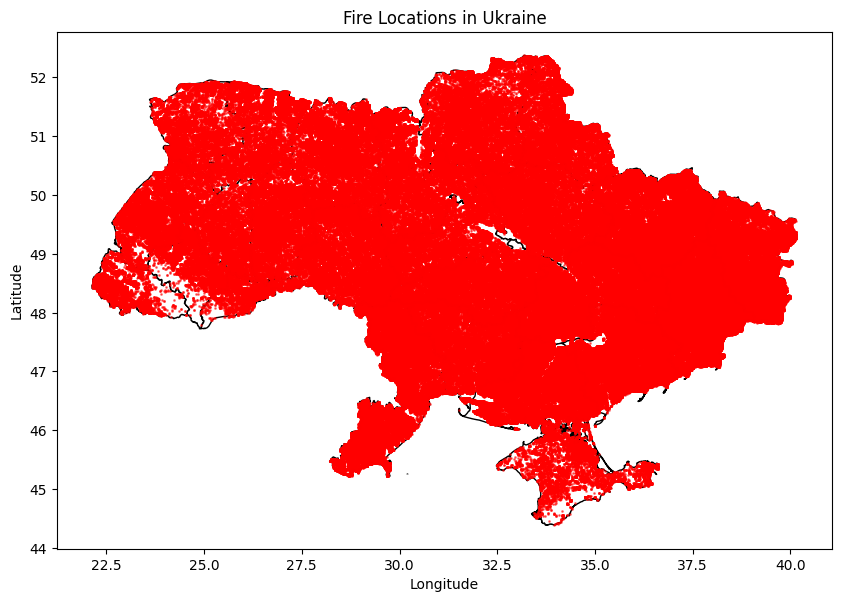

In [25]:
import matplotlib.pyplot as plt

# Load the shapefile containing the administrative borders of Ukraine
ukraine_borders = gpd.read_file('input_data/raw/ukr_borders/ua.shp')

# Ensure the fire_sample is a GeoDataFrame
fire_data_gdf = gpd.GeoDataFrame(fire_data, geometry=gpd.points_from_xy(fire_data.LONGITUDE, fire_data.LATITUDE))

# Set the same coordinate reference system (CRS) for both GeoDataFrames
fire_data_gdf.set_crs(epsg=4326, inplace=True)
ukraine_borders.set_crs(epsg=4326, inplace=True)

# Plot the Ukraine map and the fire locations
fig, ax = plt.subplots(figsize=(10, 10))
ukraine_borders.plot(ax=ax, color='white', edgecolor='black')
fire_data_gdf.plot(ax=ax, color='red', markersize=1, alpha=0.5)
plt.title('Fire Locations in Ukraine')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

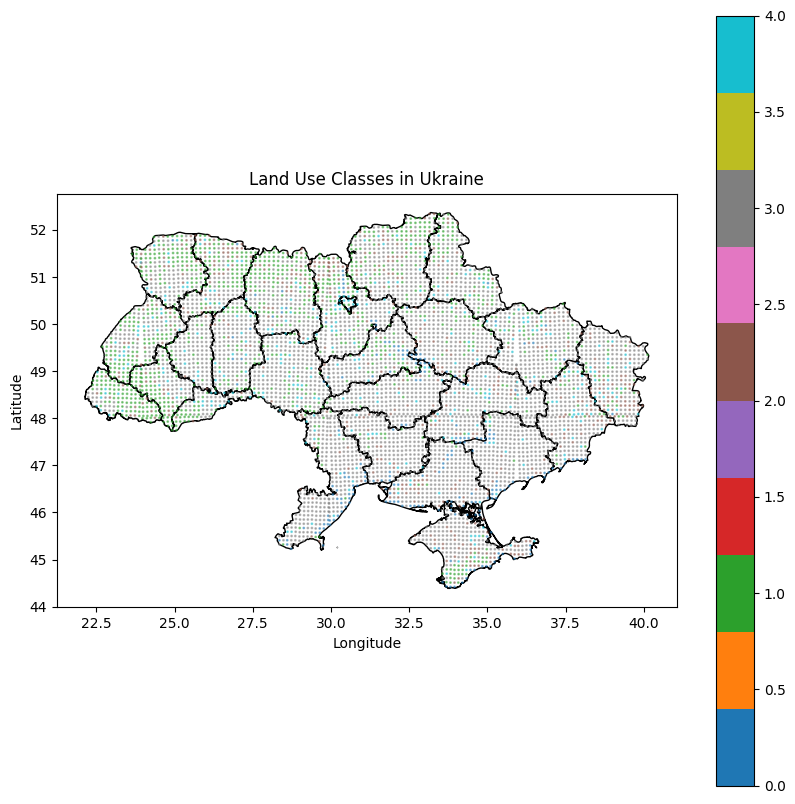

In [19]:
# Ensure the land_use_data is a GeoDataFrame
land_use_data_gdf = gpd.GeoDataFrame(land_use_data, geometry=gpd.points_from_xy(land_use_data.LONGITUDE, land_use_data.LATITUDE))

# Set the same coordinate reference system (CRS) for both GeoDataFrames
land_use_data_gdf.set_crs(epsg=4326, inplace=True)

# Plot the Ukraine map and the land use classes
fig, ax = plt.subplots(figsize=(10, 10))
ukraine_borders.plot(ax=ax, color='white', edgecolor='black')
land_use_data_gdf.plot(ax=ax, column='CLASS', legend=True, markersize=1, alpha=0.5, cmap='tab10')
plt.title('Land Use Classes in Ukraine')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()